In [1]:
!pip install git+https://github.com/kaanaksit/odak.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/kaanaksit/odak.git to /tmp/pip-req-build-v05b7lai
  Running command git clone -q https://github.com/kaanaksit/odak.git /tmp/pip-req-build-v05b7lai
     |████████████████████████████████| 3.1 MB 5.1 MB/s 
  Created wheel for odak: filename=odak-0.2.1-py3-none-any.whl size=117078 sha256=b39e57f3b6b53e8ac8efad5f8187af16096e88cbd9ed4d12a209ac206cb77e47
  Stored in directory: /tmp/pip-ephem-wheel-cache-ozhufd7t/wheels/d5/00/3c/4e341f18b6968ce909001cd30304934b45bdbb5e38ae6c41b5
Successfully built odak
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2
    Uninstalling Pillow-7.1.2:
      Successfully uninstalled Pillow-7.1.2


In [1]:
import odak
import torch 
import numpy as np 
import odak.learn.raytracing as ODL
import matplotlib.pyplot as plt
import math
import odak.raytracing as raytracer
import odak.tools as tools
import odak.raytracing as raytracer
import torch.nn as nn
from odak.raytracing.ray import create_ray
import cv2
from PIL import Image
import sys
import torch.optim as optim
from torchvision import transforms
from torch.nn import Module
import math

In [19]:

class aperture_array():

  def __init__(self, device):
    self.device = device
    self.init_light_sources()
    self.init_aperture_array()
    self.init_detector()
   
    

  def transform_image(self, image):
    """
    Resizes image, Transforms image to tensor and normalises image 

    Parmeters
    ----------
    Image     : Grayscale or Coloured PIL image

    Returns
    ---------
    normalised_image    : Tesnor of normalised and resized image

    """

    #If grayscale then:
    if(len(np.array(image).shape)<3):

      transform =transforms.Compose([
        transforms.Resize((28,28)),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5))
        
      ])
      im=transform(image)

      normalised_image = im.view(-1,1).to(self.device)

   
    #If it is a colour image then:
    elif int(np.array(image).shape[2]) == 3 or int(np.array(image).shape[2]) == 4: 
      
      transform = transforms.Compose([
          transforms.ToTensor(),
          transforms.Resize((28,28)),

      ])

      pixel = np.asarray(image)
      # convert from integers to floats
      pixel = pixel.astype('float32')
      # normalize to the range 0-1
      pixel /= 255.0

      im = torch.moveaxis(transform(pixel[:,:,:3]), 0,2)
      normalised_image = im.view(-1,3).to(self.device)    
    return normalised_image

  # initialising light sources  
  def init_light_sources(self, dimensions=[0.01, 0.015], pixel_count=[28,28], Z=0.):

      """
      Defines the light sources locations   


      """
      x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
      y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
      X, Y = torch.meshgrid(x, y, indexing='ij')
      self.light_source_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
      self.light_source_locations[:, :, 0] = X
      self.light_source_locations[:, :, 1] = Y
      self.light_source_locations[:, :, 2] = Z
      
    # Defining Array
  def init_aperture_array(self, dimensions=[0.01, 0.015], pixel_count=[28,28], Z=0.01):

        """
        Defines the aperture array and its locations

        Returns
        -------

        self.aperture_array   : A 28 x 28 Tensor of random values
                                

        """

        x = torch.linspace(-dimensions[0]/2., dimensions[0]/2., pixel_count[0])
        y = torch.linspace(-dimensions[1]/2., dimensions[1]/2., pixel_count[1])
        X, Y = torch.meshgrid(x, y, indexing='ij')
        self.aperture_array_locations = torch.zeros(X.shape[0], X.shape[1], 3).to(self.device)
        self.aperture_array_locations[:, :, 0] = X
        self.aperture_array_locations[:, :, 1] = Y
        self.aperture_array_locations[:, :, 2] = Z
        self.aperture_array = torch.rand(X.shape[0], X.shape[1], requires_grad=True, device=self.device) 

        return self.aperture_array
        
    # Defining plane   
  def init_detector(self, dimensions=[0.01, 0.015], size=[28,28], Z=0.01):
        """
        Defines planar surface

        """

        point = torch.tensor([0., 0., Z]).to(self.device)
        self.detector_surface = odak.learn.raytracing.define_plane(point)
        
  # Forming image on detector surface
  def intersection_points_to_image(self, points, amplitudes, threshold, norm_image):
        """
        Displays image generated from the intersection points from ray tracing 
        
        Paremeters
        ----------
        
        points  : Tensor containing intersection point of the ray on the planar surface

        amplitudes:  Tensor of the aperture array 

        threshold:  1x1 Tensor of the distance between pixels on the detector surface

        norm_image   : Tensor of the normalised and resized image

        Returns
        ---------

        detector_image  : Tensor containing the image formed from intersection points on the image plane
        """
        Points_data= norm_image * amplitudes
        detector = torch.zeros_like(norm_image).to(self.device)
        array_locations = self.aperture_array_locations.view(-1, 3)

  
        for idx, point in enumerate(points):
            
            dist_btwn_array_npoint = torch.sqrt(torch.sum((array_locations-point)**2, dim=1))
            min_dist_idx  = torch.argmin(dist_btwn_array_npoint)
            min_dist = torch.min(dist_btwn_array_npoint)

            if min_dist < (math.sqrt(2) * threshold):
              detector[min_dist_idx] = Points_data[idx]

        detector +=detector

        # resizing depending on if image is colour or grayscale
       
        if int(norm_image.size()[1]) == 3: 
          detector_image  = detector.view(28,28,3).to(self.device)
        else:
          detector_image  = detector.view(28,28).to(self.device)  
              
        return detector_image

  # Forward to do ray tracing return intersection points and get image
  def forward(self, array, image):

        """
        Calculates the intersection points of the ray with the planar surface
        and returns the resultant image

        Parameters
        ----------

        array:   Tensor containing the aperture array 

        image:  PIL image 

        Returns
        --------
        detector_image:   Tensor of resultant image from ray tracing 
        
        intersections:    List containing the intersection points of the ray with the plane

        """

        light_source_locations = self.light_source_locations.view(-1, 3)

        aperture_array_locations = self.aperture_array_locations.view(-1, 3)

        self.pixel_pitch = torch.sqrt(torch.sum((aperture_array_locations[1] - aperture_array_locations[0])**2, dim =0)).to(self.device)

        aperture_array = array.view(-1,1).to(self.device)
        
        self.norm_img = self.transform_image(image) 
        
        intersections = []
        
        for light_source_location in light_source_locations:
            rays_from_light_source = odak.learn.raytracing.create_ray_from_two_points(light_source_location, aperture_array_locations)

             # calculating intersection points
            intersection_normals_w_detector, _ = odak.learn.raytracing.intersect_w_surface(rays_from_light_source, self.detector_surface)
            intersection_points_w_detector = intersection_normals_w_detector[:, 0]
            intersections.append(intersection_points_w_detector)
            
            
        # Getting the image seen on the image plane
        image=list(map(self.intersection_points_to_image,intersections,[aperture_array],[self.pixel_pitch],[self.norm_img] ))
        detector_image =  image[0]
        
        return detector_image, intersections

  def compute_loss(self, output , target):
    """
    Calculates the mean square error between two values
    
    Parameters
    ----------

    output:   Tensor of image from ray tracing 

    target:   Tensor of the normalised input image 

    Returns
    ---------

    loss:  Tensor of the mean squared loss value 
    
    """

    loss = torch.nn.MSELoss()(output, target)

    return loss
            
  def optimize(self, intersection_points):

        """
        Optimises the aperture array with stochastic gradient descent 

        Parameters
        ----------

        intersection_points:  List containing the intersection points of the ray with the plane

        Returns
        ---------
        model:    Tensor of the optimised array 
        
        history:  List containing loss value in every iteration        

        """
        
       
        if int( self.norm_img.size()[1]) == 3: 
          target  = self.norm_img.view(28,28,3)
        else:
          target  = self.norm_img.view(28,28) 

        array = self.aperture_array.view(-1,1)
        array_loc = self.aperture_array_locations

        model = [nn.Parameter(array)]

        points= intersection_points
        threshold= self.pixel_pitch

       
        optimiser= torch.optim.SGD(model,lr = 0.5,momentum=0.9)
        epochs= 100

        history =[]

        for epoch in range(0, epochs+1):
          optimiser.zero_grad()
          
          output=self.intersection_points_to_image(points, model[0], threshold, self.norm_img)
          loss = self.compute_loss(output,target)
            
          loss.backward()
          optimiser.step()

          print('Epoch: ', epoch,' ,Loss: ', loss)
          history.append(loss)
          
        return model, history
  
def main():
    device = torch.device('cuda')
    apertures = aperture_array(device=device)
    result = apertures.optimize()
    return True







## Calling the module and setting the device to 'cuda'

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Aperture_RT= aperture_array(device)

# Retriving test Image

In [33]:
#Image preprocessing 

test_im_5 = Image.open('/content/heart.png')

pixel = np.asarray(test_im_5)

# convert from integers to floats
pixel = pixel.astype('float32')
# normalize to the range 0-1
pixel /= 255.0
# test_im_5 = pixel[:,:,:3]
# test_im_5 = Image.fromarray(np.uint8(pixel))


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),

])

resize_image = torch.moveaxis(transform(pixel[:,:,:3]).to(device), 0,2)



In [34]:
array = Aperture_RT.init_aperture_array()# initial value of the aperture array yet to be optimised
ray_traced_image_5, intersection_points= Aperture_RT.forward(array,test_im_5)

Text(0.5, 1.0, 'Image ray traced through array')

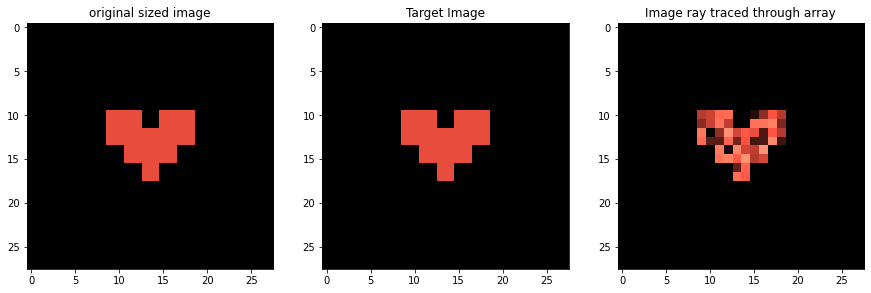

In [35]:
fig , axes=plt.subplots(1,3, figsize =(15, 15))

axes[0].imshow(resize_image.cpu().numpy())
axes[0].set_title('original sized image')

axes[1].imshow(resize_image.cpu().numpy())
axes[1].set_title('Target Image')

axes[2].imshow(ray_traced_image_5.detach().cpu().numpy())
axes[2].set_title('Image ray traced through array')

Text(0.5, 1.0, 'Randomised aperture array')

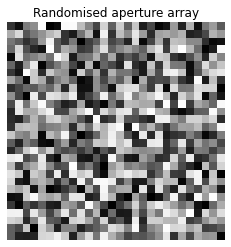

In [22]:
plt.imshow(array.detach().cpu().numpy(), cmap='gray')
plt.axis('off')
plt.title('Randomised aperture array')

In [ ]:
Loss = Aperture_RT.compute_loss(ray_traced_image_5, resize_image)
print('The initial loss is: ',Loss)

The initial loss is:  tensor(0.0073, device='cuda:0', grad_fn=<MseLossBackward0>)


# Optimising the array 

In [ ]:
# optim = Aperture_RT.optimize(intersection_points)


In [ ]:
# # save optimised array
# path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array_5.pt}"
# torch.save(optim[0][0], path)

In [26]:
# Load Optimised array
path="/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Models/{optim_array_1.pt}"
optim_array_1  = torch.load(path)


In [28]:
optimised_image_5, intersection_points=Aperture_RT.forward(optim_array_1,test_im_5)

Text(0.5, 1.0, 'Optimised image')

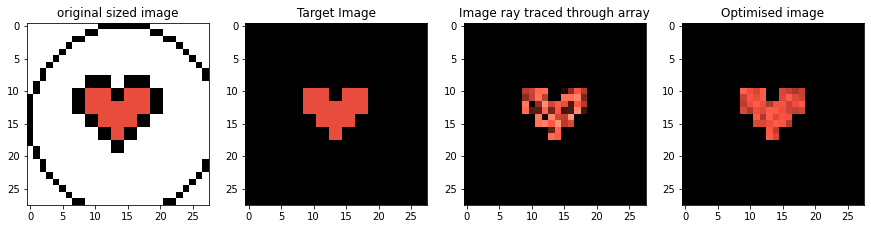

In [36]:
fig , axes=plt.subplots(1,4, figsize =(15, 15))

axes[0].imshow(test_im_5, cmap='gray')
axes[0].set_title('original sized image')

axes[1].imshow(resize_image.cpu().numpy(), cmap='gray')
axes[1].set_title('Target Image')

axes[2].imshow(ray_traced_image_5.detach().cpu().numpy())
axes[2].set_title('Image ray traced through array')


axes[3].imshow(optimised_image_5.detach().cpu().numpy())
axes[3].set_title('Optimised image')


In [37]:
# calculating error between ray traced image and optimised array
Loss = Aperture_RT.compute_loss(optimised_image_5, resize_image.squeeze())
print('The loss after optimisation is: ',Loss)

The loss after optimisation is:  tensor(0.0005, device='cuda:0', grad_fn=<MseLossBackward0>)


# Plot Convergence History 

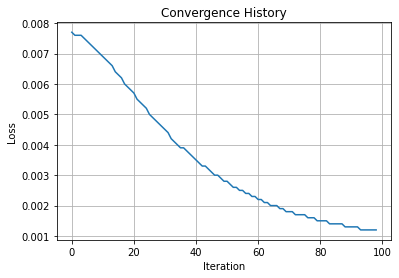

In [ ]:
plt.plot(optim[1])
plt.title('Convergence History')
plt.grid()
plt .xlabel('Iteration')
plt.ylabel('MSE Loss')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MASTERS PROJECT /Tests/Test_5/Convergence_history.png')
plt.show()